In [21]:
import sys
import os
sys.path.append("../../../../src/")
#Imports
import numpy as np
import scipy as sp
import numpy.linalg as la
import matplotlib.pyplot as plt
#Custom made imports
import single_particle_sector as sps
from time import time

In [22]:
###Functions
def En(L,J,h,OBC):

    ###SET BOUNDARY CONDITIONS
    if OBC == True:
        bc = ["OBC","OBC"]
    else:
        bc = ["ABC","PBC"]
    #empty matrices
    ns = []
    Es = []
    Us = []
    for p in range(0,2):
        #Set boundary condition
        boundary_condition = bc[p]
        #Solve for eigenvectors
        H = sps.H_bdg(h,L,J,boundary_condition)
        E, V = la.eigh(H)
        U = V.copy()
        #Solve for ground state correlations to determine parity
        V = V[:,:L]
        E = E[L:]
        G = sps.G_tfim(V)
        F = G[:L,L:]
        G = G[:L,:L]
        M = np.eye(L)-2*(G+F)
        n = la.det(M)*(-1)**L * (-1)**p

        #Append Eigenvalues for ground state
        Es.append(E)
        ns.append(n)
        Us.append(U)
    return  Es, ns,Us


def Zi(p,beta,Es,ns):
    E = sum(Es[p])
    Z =  (np.prod(1+np.exp(-beta*2*Es[p]))+ns[p]*np.prod(1-np.exp(-2*beta*Es[p])))/2
    return Z

def Z(beta,Es,ns):
   return Zi(0,beta,Es,ns)+Zi(1,beta,Es,ns)

def F(beta,Es,ns):
    return -np.log(Z(beta,Es,ns))/beta


def cap(p,mu,beta,Es,ns):
    pf = np.exp(-2*beta*Es[p][mu])/2/Z(beta,Es,ns)
    E = Es[p].copy()
    E = np.delete(E,mu)
    term1 = np.prod(1+np.exp(-2*beta*E))
    term2 = ns[p]*np.prod(1-np.exp(-2*beta*E))
    return pf*(term1-term2)

def acp(p,mu,beta,Es,ns):
    pf = 1/2/Z(beta,Es,ns)
    E = Es[p].copy()
    E = np.delete(E,mu)
    term1 = np.prod(1+np.exp(-2*beta*E))
    term2 = ns[p]*np.prod(1-np.exp(-2*beta*E))

    return pf*(term1+term2)

def ca(mu,beta,Es,ns):
    return cap(0,mu,beta,Es,ns)+cap(1,mu,beta,Es,ns)
def ac(mu,beta,Es,ns):
    return acp(0,mu,beta,Es,ns)+acp(1,mu,beta,Es,ns)
def E_p(p,beta,Es,ns):
    E = Es[p]
    Hp = sum([2*E[mu]*(ca(mu,beta,Es,ns)-1/2) for mu in range(L)])
    return Hp
def E_th(beta,Es,ns):
    return (E_p(0,beta,Es,ns)+E_p(1,beta,Es,ns))/2

In [23]:
#Model Parameters
L = 10
J = -1
h = 0
OBC = False
Es, ns,Us = En(L,J,0,False)
Z(0.000001,Es,ns)


np.float64(1023.9897600563193)

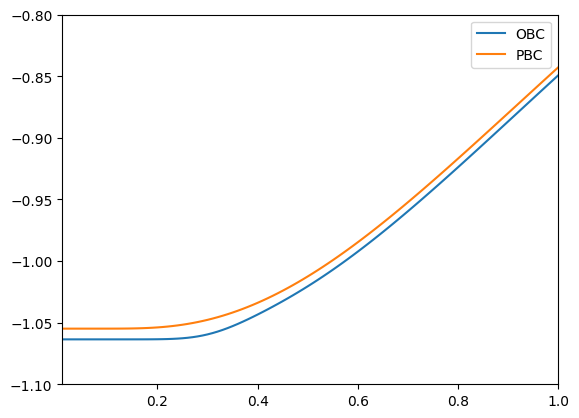

In [24]:
##Recreating Figure
T = np.linspace(0.01,1,100)
h =  0.5
L = 100
Es, ns,_ = En(L,J,h,False)
E1 = [E_th(1/ti,Es,ns)/L for ti in T]
Es, ns,_ = En(L,J,h,True)
E2 = [E_th(1/ti,Es,ns)/L for ti in T]
plt.plot(T,E1,label="OBC")
plt.plot(T,E2, label="PBC")
plt.ylim(-1.1,-.8)
plt.legend()
plt.xlim(T[0],T[-1])
plt.show()
plt.close()

In [25]:
## CORRECT VALUES OF S

L = 10
J = -1
OBC = False
beta = 0.01
hi = [0, 1/2, 1, 2]
for h in hi:
    print(f"h value = {h}")
    Es, ns,_ = En(L,J,h,OBC)
    ####If lowest energy per site is defined this way it works!!!!!!
    Ei = E_th(beta,Es,ns)+np.sum(Es)/2
    #Alternatively redefine the Free energy
    #(This probably smarter)
    Fi = F(beta,Es,ns) #- np.sum(Es)/2


    print((Ei*beta-Fi*beta)/L)
    #print(ns)
    
    print("\n")


h value = 0
0.6930971830598341


h value = 0.5
0.6930849909642604


h value = 1
0.6930484575703538


h value = 2
0.6928984836592113




LINEAR ALGEBRA


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


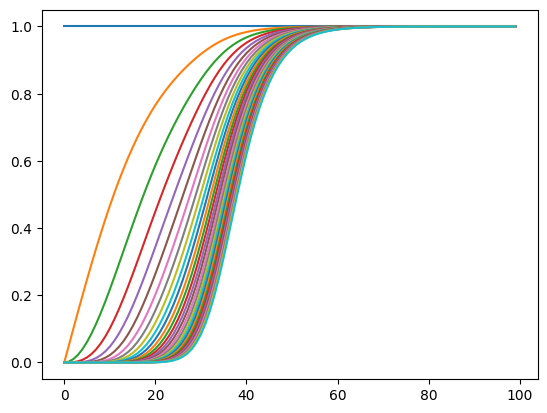

In [26]:
#EQUATION 292
L = 30
h=0
betas = np.linspace(0,5,100)
dat = []
for nx in range(L):
    print(nx)
    dat_n =[]
    for beta in betas:

        Es, ns,Us = En(L,J,h,False)

        acp(0,0,beta,Es,ns)
        op = np.diag([acp(0,i,beta,Es,ns) for i in range(L)]+[cap(0,i,beta,Es,ns) for i in range(L)])
        U1  =Us[0]
        G1 =U1@op@U1.T.conj()
        op = np.diag([acp(1,i,beta,Es,ns) for i in range(L)]+[cap(1,i,beta,Es,ns) for i in range(L)])
        U2  =Us[1]
        G2 = U2@op@U2.T.conj()
        Gth = G1+G2

        ##THERMAL SIGMA_XX

        F = Gth[:L,L:]
        G = Gth[:L,:L]
        M = np.eye(L)-2*(G+F)
        j1 = 0
        j2 = nx

        n = j2-j1
        C = np.zeros((n,n))
        for jx in range(n):
            for jy in range(n):
                C[jx,jy]= M[j1+jx,jy+1+j1]
   
        dat_n.append(la.det(C))
    dat.append(dat_n)

for d in dat:
    plt.plot(d)

In [27]:
###Functions
def E_prep(L,J,h,OBC):
    ###SET BOUNDARY CONDITIONS
    if OBC == True:
        bc = ["OBC","OBC"]
    else:
        bc = ["ABC","PBC"]
    #empty matrices
    ns = []
    Vs = []
    for p in range(0,2):
        #Set boundary condition
        boundary_condition = bc[p]
        #Solve for eigenvectors
        H = sps.H_bdg(h,L,J,boundary_condition)
        E, V = la.eigh(H)
        Vs.append([E,V])
        #Solve for ground state correlations to determine parity
        V = V[:,:L]
        E = E[L:]
        G = sps.G_tfim(V)
        F = G[:L,L:]
        G = G[:L,:L]
        M = np.eye(L)-2*(G+F)
        n = la.det(M)*(-1)**L * (-1)**p

        ns.append(n)
    return  Vs, ns


def G_thermal(Vs,ns,beta):
    def ca(n,mu,E,beta,Z):
        #Define Positive Energies
        Epos = E[L:]
        #Prefactor
        pf = np.exp(-2*beta*Epos[mu])
        #Remove site energy from Partition
        Epos = np.delete(Epos,mu)
        #Calculate
        ca_p = (np.prod(1+np.exp(-2*beta*Epos))+
               n*np.prod(1-np.exp(-2*beta*Epos)))
        #Return normalized by /2Z
        return pf*ca_p/2/Z

    def ac(n,mu,E,beta,Z):
        #Define Positive Energies

        Epos = E[L:]
        #Remove site energy from Partition

        Epos = np.delete(Epos,mu)

        ac_p = (np.prod(1+np.exp(-2*beta*Epos))+
               n*np.prod(1-np.exp(-2*beta*Epos)))
        return ac_p/2/Z
    def Zp(n,E,beta):
        Epos = E[L:]
        return (np.prod(1+np.exp(-beta*2*Epos))+n*np.prod(1-np.exp(-2*beta*Epos)))/2
    #beta is inverse temp
    #Vs is [[E,V]0,[E,V]1]
    #Caluclate Partition Function 
    Z_p = []
    for p in range(2): #Vs is [[E,V]0,[E,V]1]
        n = ns[p]
        E,V = Vs[p]
        Z_p.append(Zp(n,E,beta))

    
    Z = np.sum(Z_p)     #Z = Z0+Z1


    #Calculate G
    Gs = []
    for p in range(2):
        n = ns[p]
        E,U= Vs[p]
        N_p= np.diag([ac(n,mu,E,beta,Z) for mu in range(L)]+[ca(n,mu,E,beta,Z) for mu in range(L)])
        Gs.append(U@N_p@U.T.conj())

    return Gs[0]+Gs[1]




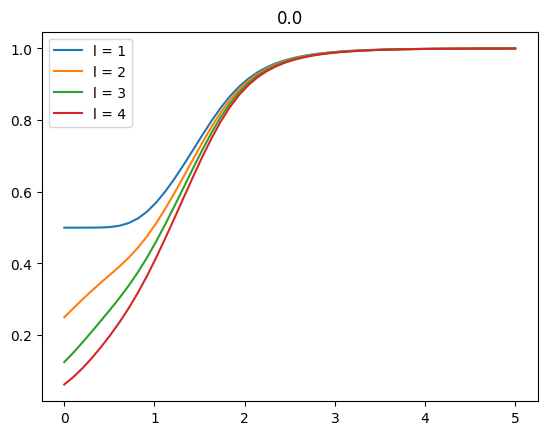

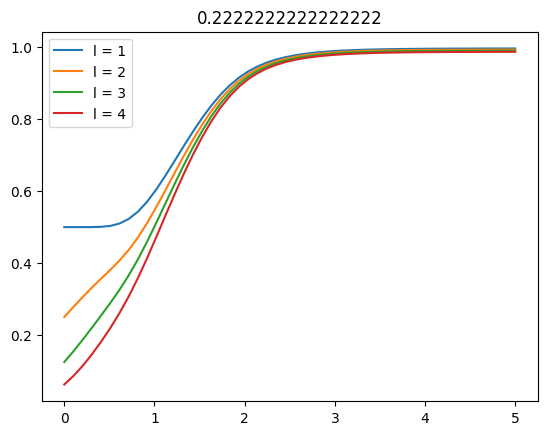

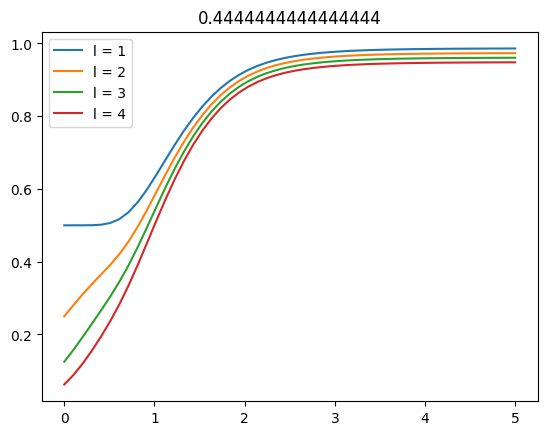

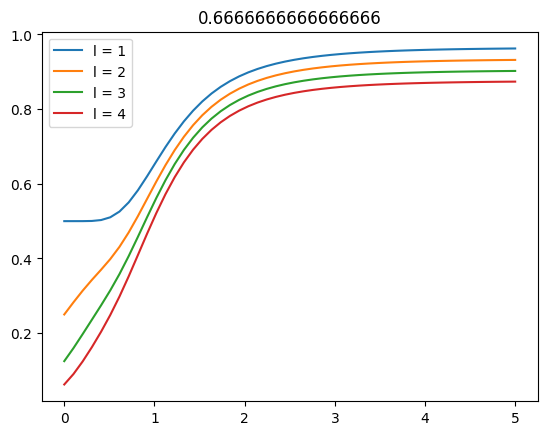

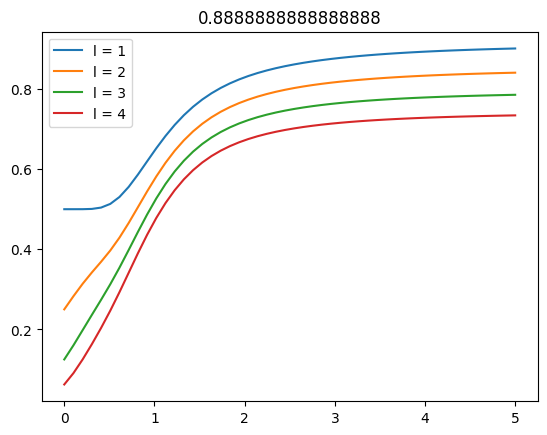

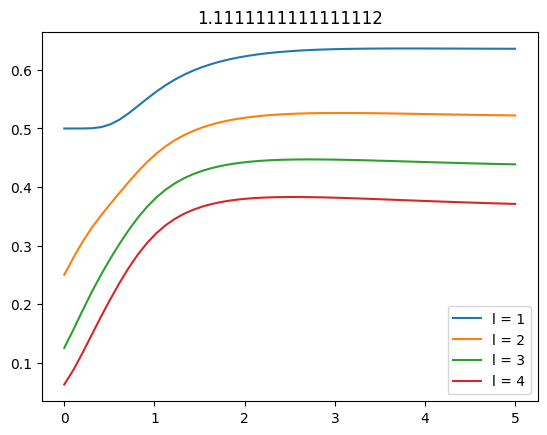

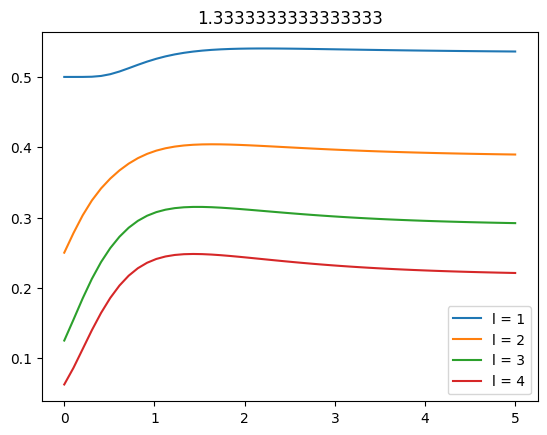

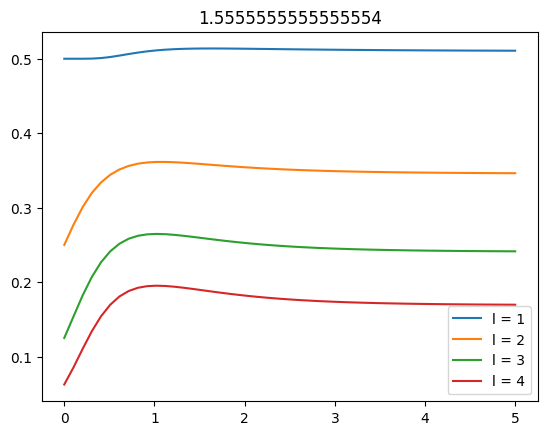

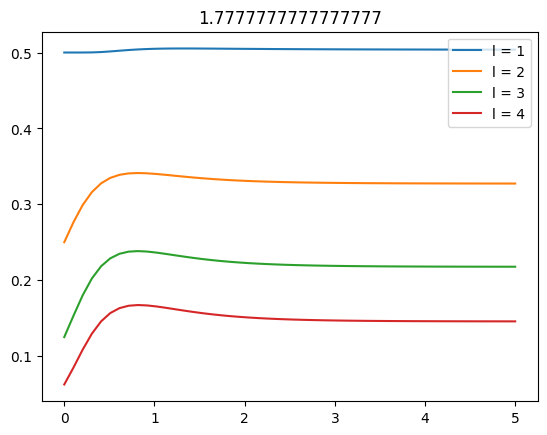

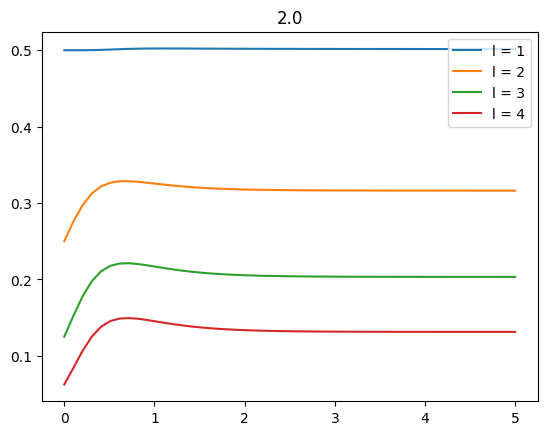

In [28]:
L = 30
J = -1
hi = np.linspace(0,2,10)
bc = False
betas = np.linspace(0,5,50)
for h in hi:
    plt.figure()
    P_n = []
    strings = []
    for n in range(1,5):
        dat= []
        for beta in betas:
            Vs, ns = E_prep(L,J,h,bc)
            G = G_thermal(Vs,ns,beta)
        
            #dat.append(  np.log(sps.P_n(2*n,G,L)/sps.P_n(n,G,L)**2))
            dat.append(sps.P_n(n,G,L))
        P_n.append(dat)
        strings.append(n)
    for p in range(len(P_n)):
        plt.plot(betas,P_n[p],label=f"l = {strings[p]}" )
        plt.title(f"{h}")
        plt.legend()

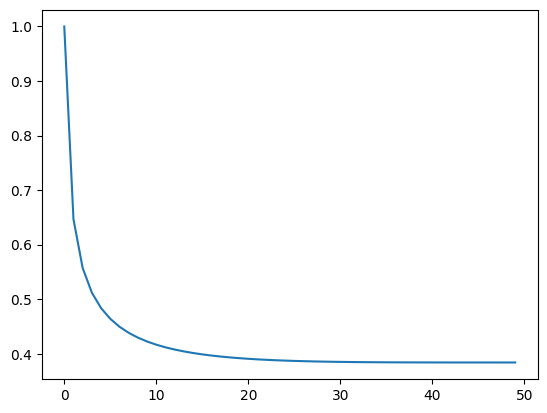

In [29]:
beta = 100
L = 50
J = -1
h = 1
Vs, ns = E_prep(L,J,h,bc)
G = G_thermal(Vs,ns,beta)
      
plt.plot([sps.sigma_general([0,i],G,L) for i in range(L)])

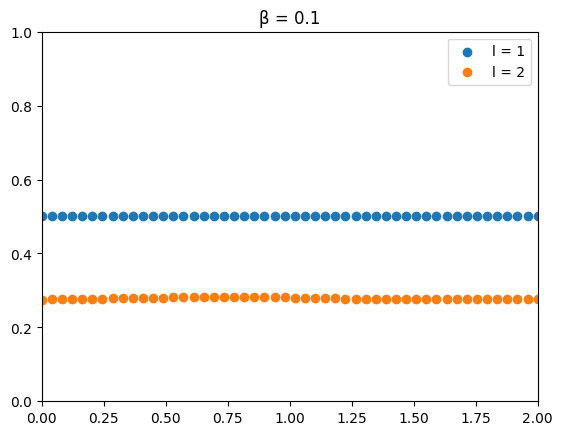

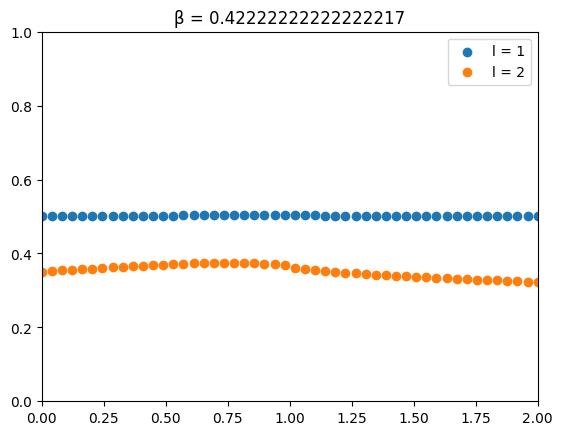

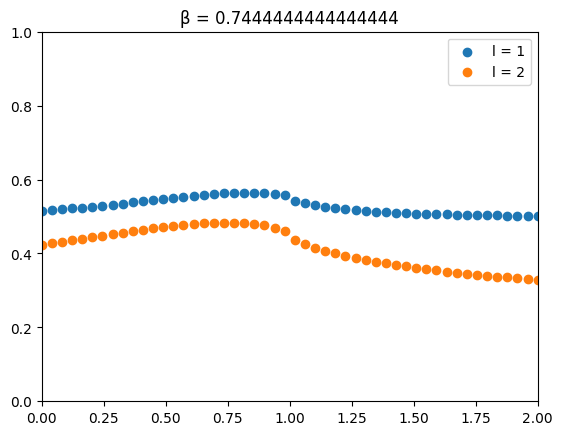

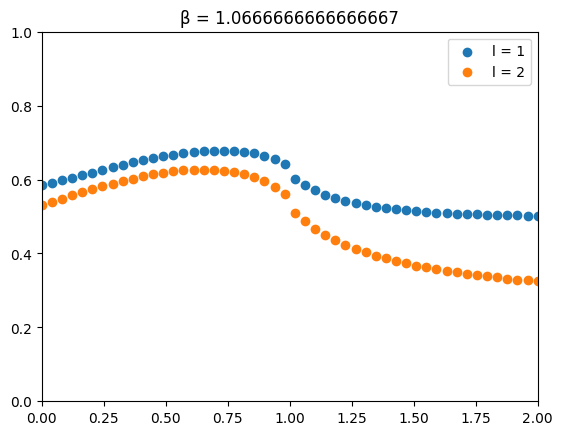

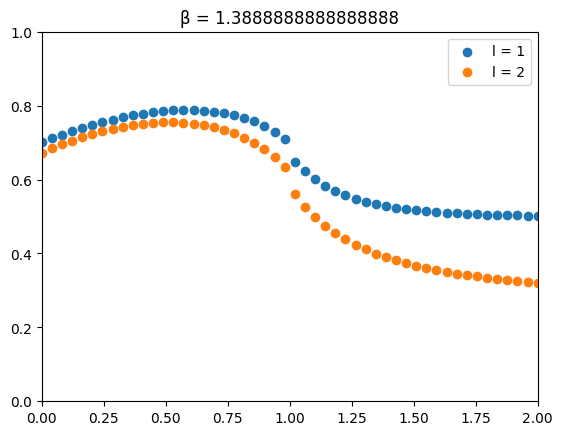

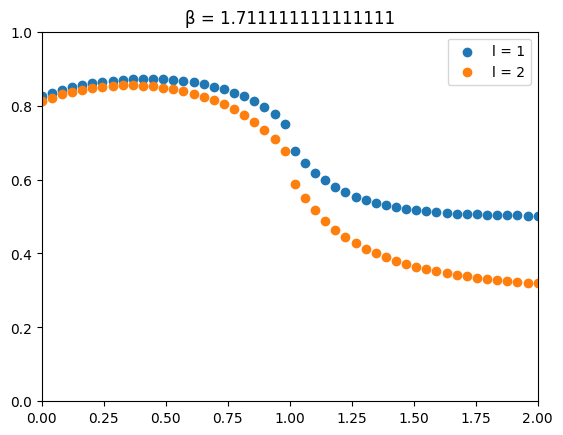

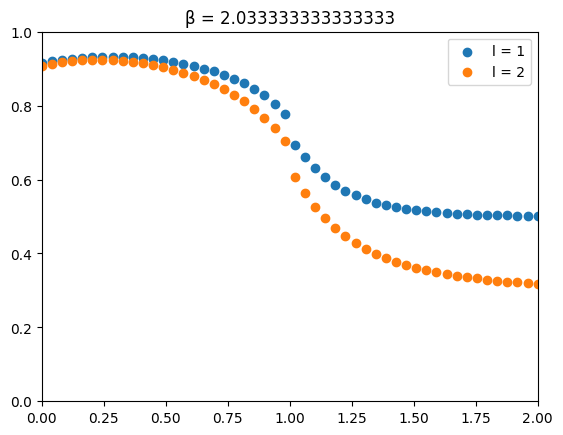

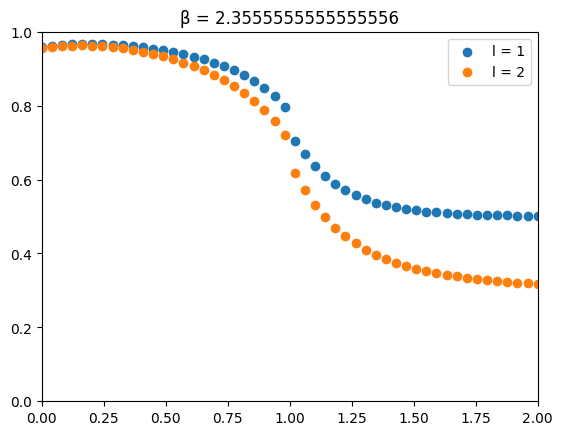

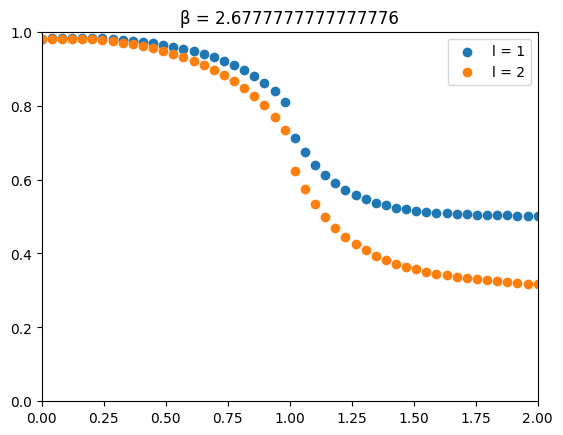

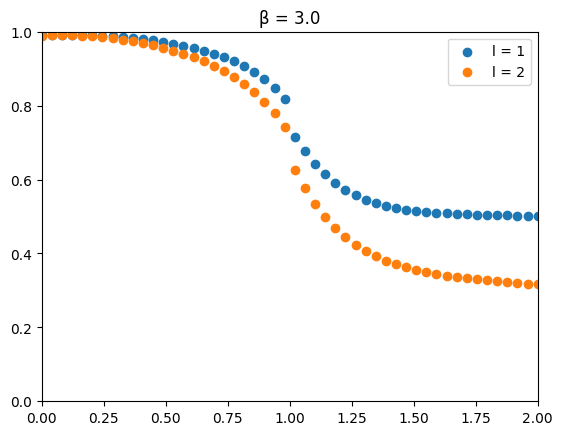

In [32]:
L = 30
J = -1
betas = np.linspace(0.1,3,10)  # example fixed β values
hi = np.linspace(0, 2, 50)
bc = False

for beta in betas:
    plt.figure()
    P_n = []
    strings = []
    for n in range(1, 3):
        dat = []
        for h in hi:
            Vs, ns = E_prep(L, J, h, bc)
            G = G_thermal(Vs, ns, beta)
            dat.append(sps.P_n(n,G,L))
        P_n.append(dat)
        strings.append(n)
    for p in range(len(P_n)):
        plt.scatter(hi, P_n[p], label=f"l = {strings[p]}")
    plt.ylim(0,1)
    plt.xlim(0,2)
    plt.title(f"β = {beta}")
    plt.legend()


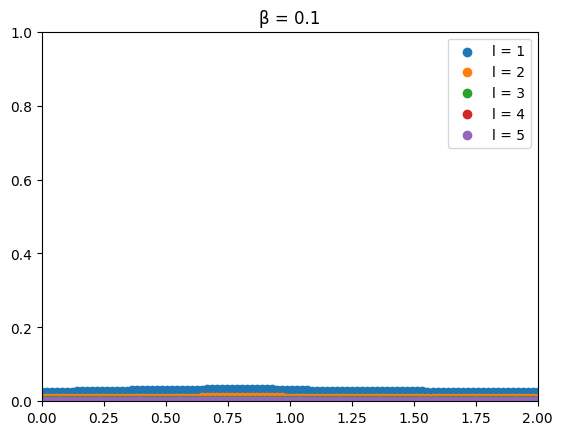

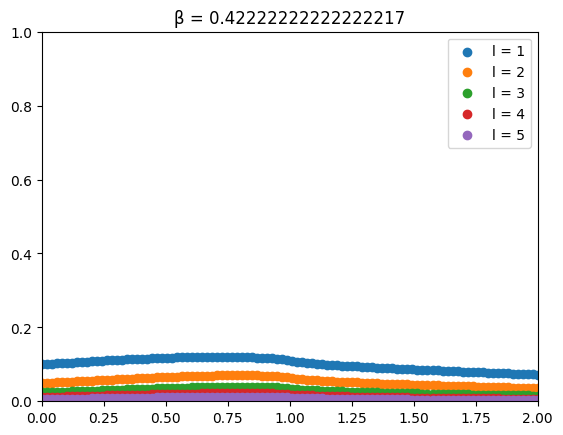

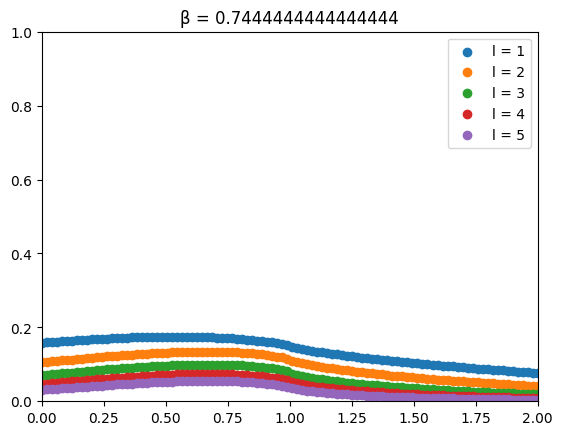

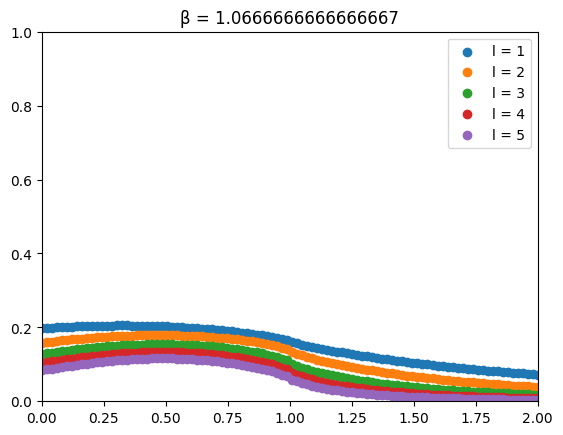

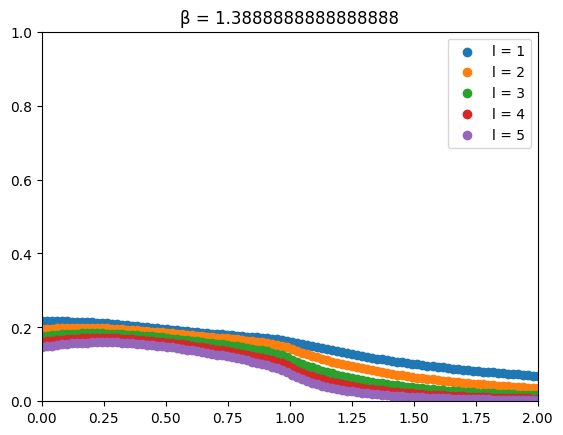

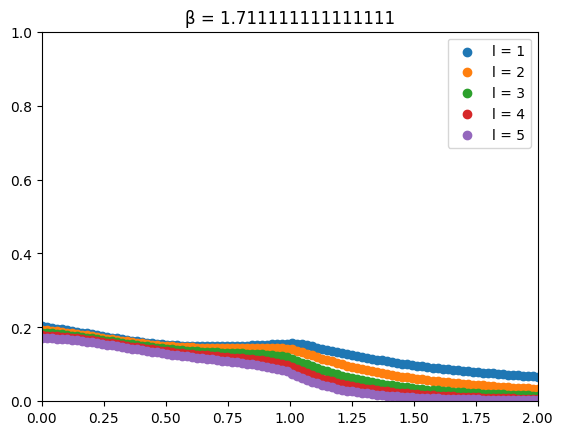

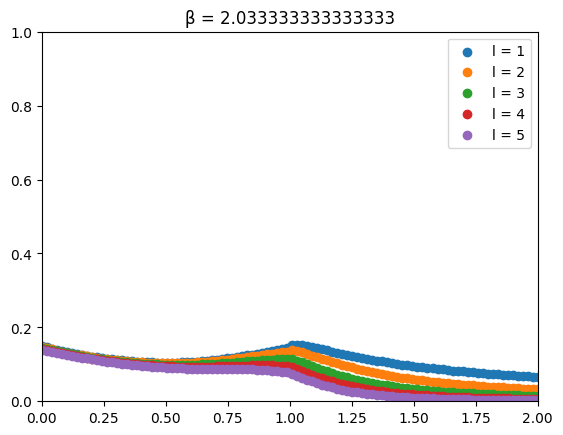

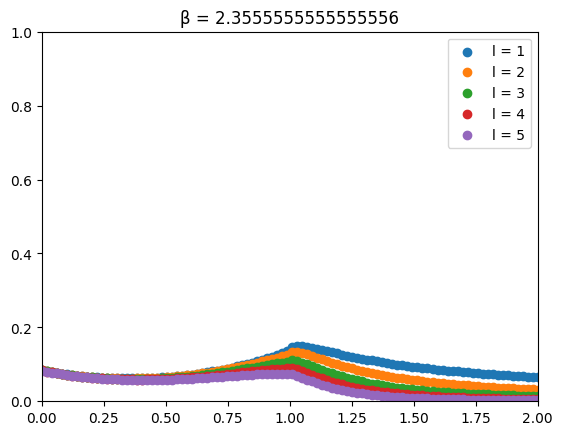

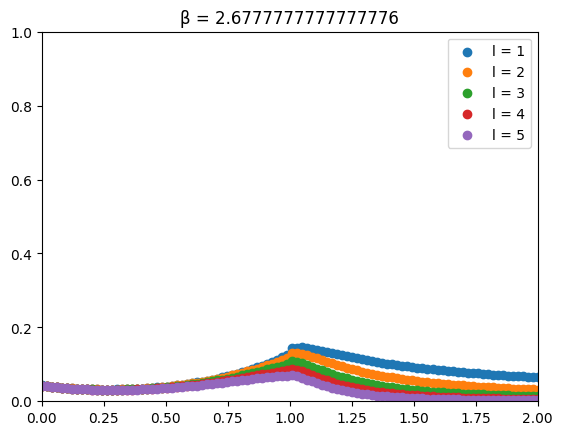

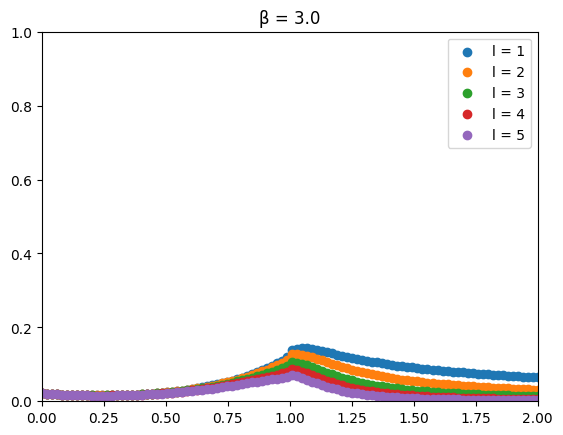

In [ ]:
L = 64
J = -1
betas = np.linspace(0.1,3,10)  # example fixed β values
hi = np.linspace(0, 2, 100)
bc = False

for beta in betas:
    plt.figure()
    P_n = []
    strings = []
    for n in range(1, 6):
        dat = []
        for h in hi:
            Vs, ns = E_prep(L, J, h, bc)
            G = G_thermal(Vs, ns, beta)
            dat.append(sps.P_n(2*n, G, L)-sps.P_n(n,G,L)**2)
        P_n.append(dat)
        strings.append(n)
    for p in range(len(P_n)):
        plt.scatter(hi, P_n[p], label=f"l = {strings[p]}")
    plt.ylim(0,1)
    plt.xlim(0,2)
    plt.title(f"β = {beta}")
    plt.legend()
